# Unstructured Model

In [1]:
import os
import copy
import torch
import pickle
import pprint
import random
import shutil
import random
import torch
import hashlib
import numpy as np
import pandas as pd
from rnn import RNN
import torch.nn as nn
from vocab import Vocab
from torch import optim
from util import *
from constants import *
from evaluator import Evaluator
from tqdm.notebook import tqdm
from sklearn.metrics import *
from transformers import AdamW
from collections import Counter
import torch.nn.functional as F
from collections import OrderedDict
from torch.autograd import Variable
from matplotlib import pyplot as plt
from sklearn.preprocessing import *
from embedding_layer import EmbeddingLayer
from attention_layer import AttentionLayer
from torch.nn.utils.rnn import pad_sequence
from gensim.models.word2vec import Word2Vec
from dataloaders import TextDataLoader, TextDataset
from gensim.models.keyedvectors import KeyedVectors
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
tqdm.pandas()

2023-04-11 09:38:18.557360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 09:38:20.820362: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!nvidia-smi

Sat Apr  8 12:15:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M40 24GB      Off  | 00000000:04:00.0 Off |                    0 |
| N/A   45C    P0    57W / 250W |  13026MiB / 22945MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40 24GB      Off  | 00000000:82:00.0 Off |                    0 |
| N/A   

In [5]:
device

device(type='cuda', index=1)

In [6]:
def read_data(file_path) -> list:
    data = pd.read_csv(file_path, on_bad_lines='skip')
    id_data = data[id_col_name]
    text_data = data[text_col_name]
    hierarchical_label_data = []
    label_data = data[label_col_name].tolist()
    output = []
    for i in tqdm(range(len(label_data)), desc="Reading data"):
        labels = label_data[i].split(';')
        output.append((text_data[i], labels, id_data[i]))
    return output

In [7]:
def read_labeldesc(file_path) -> list:
    data = pd.read_csv(file_path)
    desc_data = data[desc_col_name].tolist()
    label_data = data[label_col_name].tolist()
    output = []
    for i in tqdm(range(len(label_data)), desc="Reading Label Descriptions"):
        output.append((label_data[i], desc_data[i]))
    return output

In [8]:
def load_cached_data(file_path: str) -> tuple:
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        f.close()
    return data["vocab"], data["training_data"], data["valid_data"], data["test_data"],data["label_desc"]

In [9]:
def prepare_data():
    cache_folder = "{}/{}".format(cache_dir, "mimic3_single_32")
#     device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
    save_vocab_file_name = "{}.pkl".format("save_vocab")
    cached_file_name = os.path.join(cache_folder, save_vocab_file_name)
    if os.path.exists(cached_file_name):
        vocab, training_data, valid_data, test_data, label_desc = load_cached_data(cached_file_name)
        data = training_data + valid_data + test_data
        labels = []
        for (feature, l, _) in data:
            labels.extend(l)
        unique_labels=list(set(labels))
        n_labels = len(unique_labels)
        labels = unique_labels
        labels.extend(['I50.9', 'E78.5', 'E78.0'])
        print(labels, len(labels))
        vocab.update_labels(labels)
        print("Loaded vocab and data from file")
    else:
        training_data = read_data( data_dir + "/ensemble_train_32.csv")
        valid_data = read_data( data_dir + "/ensemble_dev_32.csv")
        test_data = read_data( data_dir + "/ensemble_test_32.csv")
        label_desc = read_labeldesc(data_dir + "/D_ICD_32.csv")
        data = training_data + valid_data + test_data
        labels = []
        for (feature, l, _) in data:
            labels.extend(l)
        unique_labels=list(set(labels))
        n_labels = len(unique_labels)
        labels = unique_labels
        labels.extend(['I50.9', 'E78.5', 'E78.0'])
        print(labels, len(labels))
        vocab = Vocab(data, labels,label_desc,min_word_frequency,
                          word_embedding_mode=embedding_mode,
                          word_embedding_file=embedding_file)
        print("Preparing the vocab")
        vocab.prepare_vocab()
        saved_objects = {"vocab": vocab,
                         "training_data": training_data,
                         "valid_data": valid_data,
                         "test_data": test_data,
                         "label_desc": label_desc}
        with open(cached_file_name, 'wb') as f:
            pickle.dump(saved_objects, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        print("Saved vocab and data to files")
    return training_data, valid_data, test_data ,label_desc, vocab,cached_file_name

In [10]:
training_data, valid_data, test_data, label_desc, vocab, saved_vocab_path = prepare_data()

['G47.33', 'F17.200', 'E03.9', 'I25.10', 'D64.9', 'J18.9', 'E11.9', 'F32.9', 'D69.6', 'N17.9', 'Z87.891', 'E66.9', 'I48.91', 'E66.01', 'I10', 'I12.0', 'R56.9', 'Z79.4', 'F05', 'J45.909', 'D62', 'R65.21', 'N39.0', 'R78.81', 'M81.0', 'Z95.1', 'N18.6', 'E46', 'R65.20', 'I50.9', 'E78.5', 'E78.0'] 32
Loaded vocab and data from file


In [11]:
model = RNN(vocab, device)
model

RNN(
  (embedding): EmbeddingLayer(
    (embeddings): Embedding(89980, 100)
  )
  (label_linear): Linear(in_features=100, out_features=256, bias=True)
  (rnn): LSTM(100, 256, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (attention): AttentionLayer(
    (first_linear): Linear(in_features=512, out_features=256, bias=False)
    (second_linear): Linear(in_features=256, out_features=32, bias=False)
    (third_linear): Linear(in_features=512, out_features=256, bias=False)
  )
  (classification_layer): Linear(in_features=256, out_features=32, bias=True)
)

In [12]:
class Trainer:
    def __init__(self, model: nn.Module,
                 train_dataloader: TextDataLoader,
                 valid_dataloader: TextDataLoader,
                 test_dataloader: TextDataLoader,
                 criterions,
                 optimiser,
                 scheduler,
                 vocab,
                 checkpoint_path,
                 ):
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.test_dataloader = test_dataloader
        self.criterions = criterions
        self.optimiser = optimiser
        self.scheduler = scheduler
        self.vocab = vocab
        self.multilabel = multilabel
        self.checkpoint_path = checkpoint_path
        self.n_training_labels = n_labels
        self.saved_result_path = '../model/results_32.pkl'
        self.main_metric = main_metric
        self.start_epoch = 0
        self.best_val = None
        self.saved_test_scores = None
        self.best_epoch_num = 1

    def train_single_epoch(self, index):
        self.model.train()
        self.train_dataloader.dataset.shuffle_data()
        losses = []
        true_labels = []
        pred_probs = []
        ids = []
        all_loss_list = []
        progress_bar = tqdm(self.train_dataloader, unit="batches", desc="Training at epoch #{}".format(index))
        progress_bar.clear()
        self.optimiser.zero_grad()
        batch_id = 0

        for text_batch, label_batch, length_batch, id_batch, desc_batch in progress_bar:
            batch_id += 1
            text_batch = text_batch.to(device)
            label_batch = label_batch.to(device)
            length_batch = length_batch.to(device)
            desc_batch = desc_batch.to(device)
            true_labels.extend(label_batch.cpu().numpy())
            ids.extend(id_batch)
            output = self.model(text_batch, length_batch,desc_batch)
            loss_list = []
            loss_list = self.criterions(output, label_batch)
            all_loss_list.append([loss_list.item()])
            output = torch.sigmoid(output)
            output = output.detach().cpu().numpy()
            pred_probs.extend(output)
            loss = get_loss(loss_list, self.n_training_labels)
            loss.backward()
            losses.append(loss.item())
            self.optimiser.step()
            self.optimiser.zero_grad()

        scores = OrderedDict()
        scores = calculate_eval_metrics(ids, true_labels,pred_probs, self.multilabel)
        scores["loss"] = np.mean(all_loss_list).item()
        scores["average"] = np.mean(losses).item()
        progress_bar.refresh(True)
        progress_bar.clear(True)
        progress_bar.close()
        keys = ['micro_auc', 'macro_auc', 'micro_f1', 'macro_f1', 'macro_P@5', 'macro_P@8', 'macro_P@15', 'loss']
        print({k:v for k,v in scores.items() if k in keys})
        return scores


    @staticmethod
    def format_number(number):
        return abs(round(number, ndigits=ndigits))

    def train(self,n_epoch: int = 100):
        best_valid_scores = self.best_val
        saved_test_scores = self.saved_test_scores
        saved_train_scores = None
        best_epoch_num = self.best_epoch_num
        evaluator = Evaluator(self.model, self.vocab, self.criterions, self.n_training_labels, device)
        for e in range(self.start_epoch + 1, n_epoch + 1):
            train_scores = self.train_single_epoch(e)
            epoch_loss = train_scores["average"]
            valid_scores = evaluator.evaluate(self.valid_dataloader)
            test_scores = evaluator.evaluate(self.test_dataloader)
            self.scheduler.step(test_scores["average"])
            print('lr {}'.format(self.optimiser.param_groups[0]['lr']))
            keys = ['micro_auc', 'macro_auc', 'micro_f1', 'macro_f1', 'macro_P@5', 'macro_P@8', 'macro_P@15', 'loss']
            print({k:v for k,v in test_scores.items() if k in keys})
            print('\n\n')
            
            if best_valid_scores is None or best_valid_scores[self.main_metric] < valid_scores[self.main_metric]:
                best_valid_scores = valid_scores
                saved_test_scores = test_scores
                saved_train_scores = train_scores
                best_epoch_num = e
                

                    
        results = {"train": saved_train_scores, "valid": best_valid_scores, "test": saved_test_scores,
                    "index2label": self.vocab.index2label}
        with open(self.saved_result_path, 'wb') as f:
            pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
                
        return self.model, best_valid_scores

In [13]:
def _load_and_cache_data(train_data, valid_data, test_data, label_desc, vocab, saved_data_file_path):
    if os.path.exists(saved_data_file_path):
        try:
            with open(saved_data_file_path, 'rb') as f:
                data = pickle.load(f)
                data["train"].multilabel = bool(multilabel)
                data["valid"].multilabel = bool(multilabel)
                data["test"].multilabel = bool(multilabel)

                return data["train"], data["valid"], data["test"]
        except:
            pass

    # Build train/valid/test data loaders
    train_dataset = TextDataset(train_data, vocab, label_desc,max_seq_length=max_seq_length,min_seq_length=min_seq_length,sort=True,multilabel=multilabel)

    valid_dataset = TextDataset(valid_data, vocab, label_desc,max_seq_length=max_seq_length,min_seq_length=min_seq_length,sort=True,multilabel=multilabel)

    test_dataset = TextDataset(test_data, vocab, label_desc,max_seq_length=max_seq_length,min_seq_length=min_seq_length,sort=True, multilabel=multilabel)
    
    # try:
    with open(saved_data_file_path, 'wb') as f:
        data = {"train": train_dataset, "valid": valid_dataset, "test": test_dataset}
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    
    return train_dataset, valid_dataset, test_dataset

In [14]:
def _train_model(train_data, valid_data, test_data, label_desc, vocab, saved_data_file_path=None,checkpoint_path=None):
    model = RNN(vocab,device)
    init_state_dict = None
    if init_state_dict is not None:
        model.load_state_dict(init_state_dict)
    model.to(device)

    train_dataset, valid_dataset, test_dataset = _load_and_cache_data(train_data, valid_data, test_data, label_desc,
                                                                      vocab, saved_data_file_path)
    
    train_dataloader = TextDataLoader(dataset=train_dataset, vocab=vocab, batch_size=batch_size)

    valid_dataloader = TextDataLoader(dataset=valid_dataset, vocab=vocab, batch_size=batch_size)

    test_dataloader = TextDataLoader(dataset=test_dataset, vocab=vocab, batch_size=batch_size)

    optimiser = torch.optim.AdamW(model.parameters(), lr = 0.001)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=1)
    
    criterions = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(2))

    trainer = Trainer(model=model,
                      train_dataloader=train_dataloader,
                      valid_dataloader=valid_dataloader,
                      test_dataloader=test_dataloader,
                      criterions=criterions,
                      optimiser=optimiser,
                      scheduler = scheduler,
                      vocab=vocab,
                      checkpoint_path=checkpoint_path)
    best_model, scores = trainer.train(n_epoch=n_epoch)

    evaluator = Evaluator(model=best_model,vocab=vocab,criterions=criterions,
                          n_training_labels=n_labels,device = device)

    del model, optimiser, evaluator, trainer, criterions
    return best_model, scores  # either on valid or test

In [15]:
def run_with_validation(training_data, valid_data, test_data, label_desc, vocab, saved_data_file_path):
    best_model, scores = _train_model(
        train_data=training_data, valid_data=valid_data, test_data=test_data, label_desc=label_desc,
        vocab=vocab, saved_data_file_path=saved_data_file_path, checkpoint_path="../model/checkpoint.pkl")

    return best_model, scores

In [16]:
# best_model, scores = run_with_validation(training_data, valid_data, test_data, label_desc, vocab, saved_data_file_path="{}.data.pkl".format(saved_vocab_path.split(".pkl")[0]))

In [17]:
# torch.save(obj = best_model.state_dict(), f = '../model/cdlaat32_for_ensemble.pth')

In [18]:
loaded_model = RNN(vocab, device)

In [19]:
loaded_model.load_state_dict(state_dict = torch.load(f = '../model/cdlaat32_for_ensemble.pth'))
# loaded_model.load_state_dict(state_dict = torch.load(f = '../model/cdlaat32_for_ensemble.pth', map_location={'cuda:3':'cuda:1'}))

<All keys matched successfully>

In [20]:
loaded_model.to(device)

RNN(
  (embedding): EmbeddingLayer(
    (embeddings): Embedding(89980, 100)
  )
  (label_linear): Linear(in_features=100, out_features=256, bias=True)
  (rnn): LSTM(100, 256, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (attention): AttentionLayer(
    (first_linear): Linear(in_features=512, out_features=256, bias=False)
    (second_linear): Linear(in_features=256, out_features=32, bias=False)
    (third_linear): Linear(in_features=512, out_features=256, bias=False)
  )
  (classification_layer): Linear(in_features=256, out_features=32, bias=True)
)

In [21]:
train_dataset, valid_dataset, test_dataset = _load_and_cache_data(training_data, valid_data, test_data, label_desc,
                                                                      vocab, '{}.teshffhfhthvhdata.pkl')


test_dataloader = TextDataLoader(dataset = test_dataset, vocab = vocab, batch_size = 32)

criterions = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(2))
evaluator = Evaluator(model = loaded_model, vocab = vocab, criterions = criterions,
                          n_training_labels = 32, device = device)

test_scores = evaluator.evaluate(test_dataloader)

Evaluating:   0%|          | 0/104 [00:00<?, ?batches/s]

In [22]:
test_scores['pred_probs'] = np.array(test_scores['pred_probs'])
test_scores['true_labels'] = np.array(test_scores['true_labels'])
test_scores['pred_probs'].shape

(3308, 32)

In [23]:
# Sorting outputs according to increasing hadm ids
# print(np.array(test_scores['true_labels']))
test_scores['hadm_ids'] = np.array(test_scores['hadm_ids'])
sort = np.argsort(test_scores['hadm_ids'])
test_scores['hadm_ids'] = test_scores['hadm_ids'][sort]
test_scores['true_labels'] = test_scores['true_labels'][sort]
test_scores['pred_probs'] = test_scores['pred_probs'][sort]
# print(test_scores['true_labels'])

In [24]:
# df = pd.read_csv('../data/dev.csv')
# train_ids_df = pd.read_csv('../../Structured/dev_final.csv')
# train_ids = list(train_ids_df['HADM_ID'])
# len(train_ids)
# train_ensemble = df.loc[df['HADM_ID'].isin(train_ids)]
# train_ensemble.to_csv('../data/ensemble_dev.csv', index = False)

In [25]:
unstruct_input = test_scores['pred_probs']

In [26]:
test_scores

{'macro_precision': 0.5247156344550732,
 'macro_recall': 0.6131983511751622,
 'macro_f1': 0.5655168421284068,
 'macro_accuracy': 0.4265326591119175,
 'macro_auc': 0.908028416892532,
 'macro_P@1': 0.8491535671100363,
 'macro_P@5': 0.5521160822249094,
 'macro_P@8': 0.4078748488512696,
 'macro_P@10': 0.3429262394195889,
 'macro_P@15': 0.24014510278113663,
 'micro_precision': 0.6531389168222956,
 'micro_recall': 0.7417407618892242,
 'micro_f1': 0.6946258737252206,
 'micro_accuracy': 0.532127808988764,
 'micro_auc': 0.9459709811793384,
 'micro_P@1': 0,
 'micro_P@5': 0,
 'micro_P@8': 0,
 'micro_P@10': 0,
 'micro_P@15': 0,
 'ids': [121804,
  105769,
  173457,
  178275,
  189104,
  142348,
  124795,
  103875,
  191832,
  152091,
  183034,
  194102,
  160912,
  174727,
  186333,
  161772,
  146046,
  102209,
  173832,
  104849,
  127683,
  136301,
  137329,
  178386,
  109204,
  198147,
  126775,
  163039,
  135595,
  172837,
  150908,
  134857,
  184692,
  111988,
  123232,
  176076,
  118704,

# Strcutured Data Pre-processing

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score

from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np

In [28]:
icd9 = ['I10','I50.9','I48.91','I25.10','N17.9','E11.9','E78.5','N39.0','E78.0','D64.9','E03.9','J18.9','D62','R65.20','F32.9','F17.200','D69.6','Z95.1','Z87.891','I12.0','R65.21','Z79.4','G47.33','J45.909','M81.0','R56.9','N18.6','E66.9','R78.81','F05','E46','E66.01']

In [29]:
icd9.sort()

In [30]:
# test_df = pd.read_csv('../data/dev_final_32.csv')
# test_df = test_df.sort_values('HADM_ID')

# df = pd.read_csv('../data/ensemble_dev_32.csv')
# df = df.sort_values('HADM_ID')
# df.to_csv('../data/ensemble_dev_32.csv', index = False)

# test_df['ICD9_CODE'] = df['ICD9_CODE'].values

# test_df.to_csv('../data/dev_final_32.csv', index = False)

In [3]:
train_df = pd.read_csv('../data/train_final_32.csv')
train_dataset = train_df.to_dict('records')
test_df = pd.read_csv('../data/test_final_32.csv')
test_dataset = test_df.to_dict('records')

dev_df = pd.read_csv('../data/dev_final_32.csv')
dev_dataset = dev_df.to_dict('records')

In [6]:
test_df

,SUBJECT_ID,HADM_ID,ICD9_CODE,51498,51478,51301,51279,51277,51275,51274,...,Nystatin-Triamcinolone Cream,Phenytoin Sodium (IV),Activated Charcoal-Sorbitol,5 Syringes (NS),Amino Acids 4.25%-Dextrose 5%,rocuronium,Sodium Chloride 3% Inhalation Soln,Prazosin,300 mcg Vial,Syringe (Sterile Water)
0,53456,100028,D69.6;I48.91,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,42255,100087,I10;E11.9;I48.91;Z87.891;J18.9,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,82593,100094,E03.9;I10;I48.91,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,65411,100098,N18.6;I10;D62;I48.91,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14297,100117,N17.9;D64.9;R65.20,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3303,15704,199716,N17.9;I10;R65.20;E11.9,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3304,43799,199813,I10;D62,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3305,26012,199816,I25.10;Z87.891;I10;Z95.1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3306,49872,199838,I25.10;N18.6;Z95.1;I48.91;Z79.4;J45.909;N39.0;...,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
def generate_dataset(dataset):
# convert df icd9_codes column into one hot vector
    for row in dataset:
        labels = [0] * 32
        codes = list(row['ICD9_CODE'].split(";"))
        for i in range(len(codes)):
            labels[icd9.index(codes[i])] = 1
        row['ICD9_CODE'] = labels

        # get list of features (lab events item ids) 
        keys = dataset[0].keys()
        keys = list(keys)
        keys.remove('SUBJECT_ID')
        keys.remove('HADM_ID')
        keys.remove('ICD9_CODE')

    # Create dataset from df feature values
    X = []
    y = []
    for row in dataset:
        x = []
        for key in keys:
            x.append(row[key])
        X.append(x)
        y.append(row['ICD9_CODE'])
    return X, y

In [33]:
X_train, y_train = generate_dataset(train_dataset)
X_test, y_test = generate_dataset(test_dataset)
X_train = np.array(X_train)
y_test = np.array(y_test)
y_train = np.array(y_train)
X_test = np.array(X_test)

In [34]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_copy = X_train
y_copy = y_train

(11333, 1529) (3308, 1529) (11333, 32) (3308, 32)


In [ ]:
corr_matrix = np.corrcoef(X_copy, y_copy, rowvar=False)[:1529, 1529:]

low_corr_features = np.where(np.abs(corr_matrix) > 0.35)[0]

X_filtered = np.delete(X_copy, low_corr_features, axis=1)

In [ ]:
X_filtered.shape

In [ ]:
print(corr_matrix)

# Random Forest Model for Structured data

In [ ]:
forest = RandomForestClassifier(random_state=1, verbose = True)
multi_target_forest = MultiOutputClassifier(forest, n_jobs = 50)
multi_target_forest.fit(X_train, y_train)

In [40]:
y_pred = multi_target_forest.predict_proba(X_test)[:, 1]
y_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

TypeError: list indices must be integers or slices, not tuple

In [71]:
for j in range(len(y_pred)):
    if y_pred[j].shape[1] == 1:
        filler = np.ones((3308, 2))
        for i in range(len(filler)):
            filler[i][1] = 0
        y_pred[j] = filler

In [72]:
y_pred = np.array(y_pred)
struct_input = y_pred[:, :, 1]
struct_input = struct_input.T
test_samples = y_test

### xgboost

In [ ]:
!pip uninstall adaboost-model

In [47]:
import sklearn
from ada_boost as AdaBoost
from xgboost import XGBClassifier
import lightgbm as lgb
gbm
multi_target_forest = MultiOutputClassifier(gbm, n_jobs = 50)
multi_target_forest.fit(X_train, y_train)

AttributeError: module 'adaboost_model' has no attribute 'AdaBoostClassifier'

In [35]:
y_pred = multi_target_forest.predict_proba(X_test)
y_pred

[array([[0.94996537, 0.05003463],
        [0.9855351 , 0.0144649 ],
        [0.95525462, 0.04474538],
        ...,
        [0.96679979, 0.03320021],
        [0.99023007, 0.00976993],
        [0.9741113 , 0.0258887 ]]),
 array([[0.92891347, 0.07108653],
        [0.95345626, 0.04654374],
        [0.98107765, 0.01892235],
        ...,
        [0.84387067, 0.15612933],
        [0.83529544, 0.16470456],
        [0.87517191, 0.12482809]]),
 array([[0.98276325, 0.01723675],
        [0.98425887, 0.01574113],
        [0.99423707, 0.00576293],
        ...,
        [0.87126729, 0.12873271],
        [0.97561949, 0.02438051],
        [0.94900212, 0.05099788]]),
 array([[0.99799701, 0.00200299],
        [0.99432006, 0.00567994],
        [0.17760968, 0.82239032],
        ...,
        [0.74640932, 0.25359068],
        [0.98842431, 0.01157569],
        [0.99834879, 0.00165121]]),
 array([[0.87621267, 0.12378733],
        [0.77480149, 0.22519851],
        [0.96538877, 0.03461123],
        ...,
        [

In [36]:
for j in range(len(y_pred)):
    if y_pred[j].shape[1] == 1:
        filler = np.ones((3308, 2))
        for i in range(len(filler)):
            filler[i][1] = 0
        y_pred[j] = filler

In [37]:
y_pred = np.array(y_pred)
struct_input = y_pred[:, :, 1]
struct_input = struct_input.T
test_samples = y_test

In [38]:
y_train.shape

(11333, 32)

In [39]:
train_df

,SUBJECT_ID,HADM_ID,ICD9_CODE,51498,51478,51301,51279,51277,51275,51274,...,Nystatin-Triamcinolone Cream,Phenytoin Sodium (IV),Activated Charcoal-Sorbitol,5 Syringes (NS),Amino Acids 4.25%-Dextrose 5%,rocuronium,Sodium Chloride 3% Inhalation Soln,Prazosin,300 mcg Vial,Syringe (Sterile Water)
0,533,100009,D64.9;I25.10;I10;E66.9;E11.9;Z79.4;Z87.891,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,87977,100011,D62,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,58128,100018,I25.10;E66.9;I48.91,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,9973,100020,N17.9;F05;N39.0;I10,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,29971,100021,N39.0;I10;I48.91;D69.6,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11328,49225,199948,N39.0;F17.200,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
11329,22711,199952,E11.9;E03.9;I10;I48.91,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11330,5478,199963,D64.9;N17.9;I25.10;I10;E11.9,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11331,20785,199993,I48.91,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### gradient boost

In [4]:
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
multi_target_forest = MultiOutputClassifier(gbm, n_jobs = 50)
multi_target_forest.fit(X_train, y_train)

NameError: name 'MultiOutputClassifier' is not defined

# Basic Ensemble Model with linear weighing of models

In [40]:
mi_auc = []
ma_auc = []
mi_f1 = []
ma_f1 = []

for alpha in np.arange(0.0, 1.0, 0.001):
    final_output = struct_input * alpha + unstruct_input * (1 - alpha)
    scores = calculate_eval_metrics(test_scores['hadm_ids'], y_test, final_output, True)
    keys = ['micro_auc', 'macro_auc', 'micro_f1', 'macro_f1']
    print('aplha: ', alpha)
    print({k:"{:.5f}".format(v) for k,v in scores.items() if k in keys})
    mi_auc.append(scores['micro_auc'])
    ma_auc.append(scores['macro_auc'])
    mi_f1.append(scores['micro_f1'])
    ma_f1.append(scores['macro_f1'])
    print('\n')

aplha:  0.0
{'macro_f1': '0.56552', 'macro_auc': '0.90803', 'micro_f1': '0.69463', 'micro_auc': '0.94597'}


aplha:  0.001
{'macro_f1': '0.56559', 'macro_auc': '0.90815', 'micro_f1': '0.69471', 'micro_auc': '0.94604'}


aplha:  0.002
{'macro_f1': '0.56570', 'macro_auc': '0.90826', 'micro_f1': '0.69486', 'micro_auc': '0.94610'}


aplha:  0.003
{'macro_f1': '0.56583', 'macro_auc': '0.90836', 'micro_f1': '0.69502', 'micro_auc': '0.94616'}


aplha:  0.004
{'macro_f1': '0.56583', 'macro_auc': '0.90846', 'micro_f1': '0.69500', 'micro_auc': '0.94622'}


aplha:  0.005
{'macro_f1': '0.56592', 'macro_auc': '0.90856', 'micro_f1': '0.69511', 'micro_auc': '0.94628'}


aplha:  0.006
{'macro_f1': '0.56593', 'macro_auc': '0.90865', 'micro_f1': '0.69530', 'micro_auc': '0.94633'}


aplha:  0.007
{'macro_f1': '0.56597', 'macro_auc': '0.90874', 'micro_f1': '0.69535', 'micro_auc': '0.94638'}


aplha:  0.008
{'macro_f1': '0.56614', 'macro_auc': '0.90882', 'micro_f1': '0.69551', 'micro_auc': '0.94643'}


apl

aplha:  0.074
{'macro_f1': '0.56249', 'macro_auc': '0.91144', 'micro_f1': '0.69674', 'micro_auc': '0.94807'}


aplha:  0.075
{'macro_f1': '0.56258', 'macro_auc': '0.91146', 'micro_f1': '0.69684', 'micro_auc': '0.94808'}


aplha:  0.076
{'macro_f1': '0.56273', 'macro_auc': '0.91148', 'micro_f1': '0.69695', 'micro_auc': '0.94809'}


aplha:  0.077
{'macro_f1': '0.56274', 'macro_auc': '0.91150', 'micro_f1': '0.69688', 'micro_auc': '0.94811'}


aplha:  0.078
{'macro_f1': '0.56273', 'macro_auc': '0.91152', 'micro_f1': '0.69689', 'micro_auc': '0.94812'}


aplha:  0.079
{'macro_f1': '0.56292', 'macro_auc': '0.91155', 'micro_f1': '0.69705', 'micro_auc': '0.94813'}


aplha:  0.08
{'macro_f1': '0.56317', 'macro_auc': '0.91157', 'micro_f1': '0.69711', 'micro_auc': '0.94814'}


aplha:  0.081
{'macro_f1': '0.56315', 'macro_auc': '0.91159', 'micro_f1': '0.69712', 'micro_auc': '0.94816'}


aplha:  0.082
{'macro_f1': '0.56327', 'macro_auc': '0.91161', 'micro_f1': '0.69720', 'micro_auc': '0.94817'}


ap

aplha:  0.148
{'macro_f1': '0.56329', 'macro_auc': '0.91245', 'micro_f1': '0.69998', 'micro_auc': '0.94866'}


aplha:  0.149
{'macro_f1': '0.56325', 'macro_auc': '0.91246', 'micro_f1': '0.70002', 'micro_auc': '0.94866'}


aplha:  0.15
{'macro_f1': '0.56312', 'macro_auc': '0.91247', 'micro_f1': '0.70002', 'micro_auc': '0.94866'}


aplha:  0.151
{'macro_f1': '0.56290', 'macro_auc': '0.91248', 'micro_f1': '0.69998', 'micro_auc': '0.94867'}


aplha:  0.152
{'macro_f1': '0.56306', 'macro_auc': '0.91248', 'micro_f1': '0.70001', 'micro_auc': '0.94867'}


aplha:  0.153
{'macro_f1': '0.56312', 'macro_auc': '0.91249', 'micro_f1': '0.70012', 'micro_auc': '0.94867'}


aplha:  0.154
{'macro_f1': '0.56312', 'macro_auc': '0.91250', 'micro_f1': '0.70023', 'micro_auc': '0.94868'}


aplha:  0.155
{'macro_f1': '0.56339', 'macro_auc': '0.91251', 'micro_f1': '0.70034', 'micro_auc': '0.94868'}


aplha:  0.156
{'macro_f1': '0.56347', 'macro_auc': '0.91252', 'micro_f1': '0.70042', 'micro_auc': '0.94869'}


ap

aplha:  0.221
{'macro_f1': '0.55726', 'macro_auc': '0.91285', 'micro_f1': '0.70155', 'micro_auc': '0.94875'}


aplha:  0.222
{'macro_f1': '0.55755', 'macro_auc': '0.91285', 'micro_f1': '0.70162', 'micro_auc': '0.94875'}


aplha:  0.223
{'macro_f1': '0.55763', 'macro_auc': '0.91285', 'micro_f1': '0.70170', 'micro_auc': '0.94875'}


aplha:  0.224
{'macro_f1': '0.55745', 'macro_auc': '0.91285', 'micro_f1': '0.70160', 'micro_auc': '0.94875'}


aplha:  0.225
{'macro_f1': '0.55745', 'macro_auc': '0.91286', 'micro_f1': '0.70175', 'micro_auc': '0.94875'}


aplha:  0.226
{'macro_f1': '0.55724', 'macro_auc': '0.91286', 'micro_f1': '0.70165', 'micro_auc': '0.94875'}


aplha:  0.227
{'macro_f1': '0.55712', 'macro_auc': '0.91286', 'micro_f1': '0.70163', 'micro_auc': '0.94875'}


aplha:  0.228
{'macro_f1': '0.55738', 'macro_auc': '0.91286', 'micro_f1': '0.70162', 'micro_auc': '0.94874'}


aplha:  0.229
{'macro_f1': '0.55736', 'macro_auc': '0.91286', 'micro_f1': '0.70160', 'micro_auc': '0.94874'}


a

aplha:  0.295
{'macro_f1': '0.54878', 'macro_auc': '0.91284', 'micro_f1': '0.70103', 'micro_auc': '0.94850'}


aplha:  0.296
{'macro_f1': '0.54898', 'macro_auc': '0.91284', 'micro_f1': '0.70115', 'micro_auc': '0.94849'}


aplha:  0.297
{'macro_f1': '0.54896', 'macro_auc': '0.91283', 'micro_f1': '0.70114', 'micro_auc': '0.94849'}


aplha:  0.298
{'macro_f1': '0.54910', 'macro_auc': '0.91283', 'micro_f1': '0.70130', 'micro_auc': '0.94848'}


aplha:  0.299
{'macro_f1': '0.54926', 'macro_auc': '0.91282', 'micro_f1': '0.70142', 'micro_auc': '0.94848'}


aplha:  0.3
{'macro_f1': '0.54918', 'macro_auc': '0.91282', 'micro_f1': '0.70142', 'micro_auc': '0.94847'}


aplha:  0.301
{'macro_f1': '0.54961', 'macro_auc': '0.91282', 'micro_f1': '0.70163', 'micro_auc': '0.94846'}


aplha:  0.302
{'macro_f1': '0.54932', 'macro_auc': '0.91282', 'micro_f1': '0.70142', 'micro_auc': '0.94846'}


aplha:  0.303
{'macro_f1': '0.54917', 'macro_auc': '0.91281', 'micro_f1': '0.70127', 'micro_auc': '0.94845'}


apl

aplha:  0.369
{'macro_f1': '0.54408', 'macro_auc': '0.91242', 'micro_f1': '0.69984', 'micro_auc': '0.94789'}


aplha:  0.37
{'macro_f1': '0.54392', 'macro_auc': '0.91241', 'micro_f1': '0.69986', 'micro_auc': '0.94788'}


aplha:  0.371
{'macro_f1': '0.54356', 'macro_auc': '0.91240', 'micro_f1': '0.69949', 'micro_auc': '0.94787'}


aplha:  0.372
{'macro_f1': '0.54323', 'macro_auc': '0.91239', 'micro_f1': '0.69941', 'micro_auc': '0.94786'}


aplha:  0.373
{'macro_f1': '0.54341', 'macro_auc': '0.91239', 'micro_f1': '0.69935', 'micro_auc': '0.94785'}


aplha:  0.374
{'macro_f1': '0.54355', 'macro_auc': '0.91237', 'micro_f1': '0.69933', 'micro_auc': '0.94784'}


aplha:  0.375
{'macro_f1': '0.54335', 'macro_auc': '0.91236', 'micro_f1': '0.69907', 'micro_auc': '0.94783'}


aplha:  0.376
{'macro_f1': '0.54292', 'macro_auc': '0.91235', 'micro_f1': '0.69871', 'micro_auc': '0.94782'}


aplha:  0.377
{'macro_f1': '0.54222', 'macro_auc': '0.91235', 'micro_f1': '0.69856', 'micro_auc': '0.94780'}


ap

aplha:  0.443
{'macro_f1': '0.52338', 'macro_auc': '0.91155', 'micro_f1': '0.69009', 'micro_auc': '0.94687'}


aplha:  0.444
{'macro_f1': '0.52336', 'macro_auc': '0.91153', 'micro_f1': '0.69002', 'micro_auc': '0.94686'}


aplha:  0.445
{'macro_f1': '0.52278', 'macro_auc': '0.91152', 'micro_f1': '0.68966', 'micro_auc': '0.94684'}


aplha:  0.446
{'macro_f1': '0.52297', 'macro_auc': '0.91150', 'micro_f1': '0.68956', 'micro_auc': '0.94682'}


aplha:  0.447
{'macro_f1': '0.52274', 'macro_auc': '0.91149', 'micro_f1': '0.68940', 'micro_auc': '0.94680'}


aplha:  0.448
{'macro_f1': '0.52148', 'macro_auc': '0.91147', 'micro_f1': '0.68878', 'micro_auc': '0.94679'}


aplha:  0.449
{'macro_f1': '0.52066', 'macro_auc': '0.91146', 'micro_f1': '0.68827', 'micro_auc': '0.94677'}


aplha:  0.45
{'macro_f1': '0.51998', 'macro_auc': '0.91144', 'micro_f1': '0.68799', 'micro_auc': '0.94675'}


aplha:  0.451
{'macro_f1': '0.51999', 'macro_auc': '0.91143', 'micro_f1': '0.68806', 'micro_auc': '0.94673'}


ap

aplha:  0.517
{'macro_f1': '0.45587', 'macro_auc': '0.91019', 'micro_f1': '0.65262', 'micro_auc': '0.94529'}


aplha:  0.518
{'macro_f1': '0.45426', 'macro_auc': '0.91016', 'micro_f1': '0.65152', 'micro_auc': '0.94526'}


aplha:  0.519
{'macro_f1': '0.45339', 'macro_auc': '0.91014', 'micro_f1': '0.65088', 'micro_auc': '0.94523'}


aplha:  0.52
{'macro_f1': '0.45333', 'macro_auc': '0.91012', 'micro_f1': '0.65059', 'micro_auc': '0.94520'}


aplha:  0.521
{'macro_f1': '0.45265', 'macro_auc': '0.91009', 'micro_f1': '0.65024', 'micro_auc': '0.94518'}


aplha:  0.522
{'macro_f1': '0.45149', 'macro_auc': '0.91007', 'micro_f1': '0.64971', 'micro_auc': '0.94515'}


aplha:  0.523
{'macro_f1': '0.45114', 'macro_auc': '0.91004', 'micro_f1': '0.64935', 'micro_auc': '0.94512'}


aplha:  0.524
{'macro_f1': '0.45000', 'macro_auc': '0.91002', 'micro_f1': '0.64871', 'micro_auc': '0.94509'}


aplha:  0.525
{'macro_f1': '0.44900', 'macro_auc': '0.90999', 'micro_f1': '0.64798', 'micro_auc': '0.94507'}


ap

aplha:  0.591
{'macro_f1': '0.40382', 'macro_auc': '0.90786', 'micro_f1': '0.61010', 'micro_auc': '0.94281'}


aplha:  0.592
{'macro_f1': '0.40344', 'macro_auc': '0.90781', 'micro_f1': '0.60960', 'micro_auc': '0.94276'}


aplha:  0.593
{'macro_f1': '0.40302', 'macro_auc': '0.90777', 'micro_f1': '0.60956', 'micro_auc': '0.94272'}


aplha:  0.594
{'macro_f1': '0.40286', 'macro_auc': '0.90773', 'micro_f1': '0.60893', 'micro_auc': '0.94268'}


aplha:  0.595
{'macro_f1': '0.40287', 'macro_auc': '0.90769', 'micro_f1': '0.60866', 'micro_auc': '0.94264'}


aplha:  0.596
{'macro_f1': '0.40202', 'macro_auc': '0.90765', 'micro_f1': '0.60791', 'micro_auc': '0.94260'}


aplha:  0.597
{'macro_f1': '0.40126', 'macro_auc': '0.90760', 'micro_f1': '0.60726', 'micro_auc': '0.94255'}


aplha:  0.598
{'macro_f1': '0.40123', 'macro_auc': '0.90757', 'micro_f1': '0.60663', 'micro_auc': '0.94251'}


aplha:  0.599
{'macro_f1': '0.40013', 'macro_auc': '0.90752', 'micro_f1': '0.60577', 'micro_auc': '0.94247'}


a

aplha:  0.665
{'macro_f1': '0.36968', 'macro_auc': '0.90402', 'micro_f1': '0.56926', 'micro_auc': '0.93905'}


aplha:  0.666
{'macro_f1': '0.36888', 'macro_auc': '0.90395', 'micro_f1': '0.56852', 'micro_auc': '0.93899'}


aplha:  0.667
{'macro_f1': '0.36876', 'macro_auc': '0.90388', 'micro_f1': '0.56832', 'micro_auc': '0.93893'}


aplha:  0.668
{'macro_f1': '0.36838', 'macro_auc': '0.90382', 'micro_f1': '0.56724', 'micro_auc': '0.93887'}


aplha:  0.669
{'macro_f1': '0.36816', 'macro_auc': '0.90375', 'micro_f1': '0.56693', 'micro_auc': '0.93881'}


aplha:  0.67
{'macro_f1': '0.36751', 'macro_auc': '0.90368', 'micro_f1': '0.56611', 'micro_auc': '0.93875'}


aplha:  0.671
{'macro_f1': '0.36707', 'macro_auc': '0.90361', 'micro_f1': '0.56572', 'micro_auc': '0.93868'}


aplha:  0.672
{'macro_f1': '0.36642', 'macro_auc': '0.90354', 'micro_f1': '0.56449', 'micro_auc': '0.93862'}


aplha:  0.673
{'macro_f1': '0.36576', 'macro_auc': '0.90347', 'micro_f1': '0.56350', 'micro_auc': '0.93856'}


ap

aplha:  0.737
{'macro_f1': '0.34505', 'macro_auc': '0.89809', 'micro_f1': '0.53836', 'micro_auc': '0.93375'}


aplha:  0.738
{'macro_f1': '0.34423', 'macro_auc': '0.89798', 'micro_f1': '0.53800', 'micro_auc': '0.93366'}


aplha:  0.739
{'macro_f1': '0.34405', 'macro_auc': '0.89788', 'micro_f1': '0.53743', 'micro_auc': '0.93357'}


aplha:  0.74
{'macro_f1': '0.34337', 'macro_auc': '0.89778', 'micro_f1': '0.53680', 'micro_auc': '0.93349'}


aplha:  0.741
{'macro_f1': '0.34312', 'macro_auc': '0.89768', 'micro_f1': '0.53637', 'micro_auc': '0.93340'}


aplha:  0.742
{'macro_f1': '0.34301', 'macro_auc': '0.89757', 'micro_f1': '0.53610', 'micro_auc': '0.93331'}


aplha:  0.743
{'macro_f1': '0.34305', 'macro_auc': '0.89747', 'micro_f1': '0.53567', 'micro_auc': '0.93322'}


aplha:  0.744
{'macro_f1': '0.34284', 'macro_auc': '0.89736', 'micro_f1': '0.53549', 'micro_auc': '0.93313'}


aplha:  0.745
{'macro_f1': '0.34284', 'macro_auc': '0.89726', 'micro_f1': '0.53532', 'micro_auc': '0.93303'}


ap

aplha:  0.811
{'macro_f1': '0.32147', 'macro_auc': '0.88865', 'micro_f1': '0.51030', 'micro_auc': '0.92591'}


aplha:  0.812
{'macro_f1': '0.32120', 'macro_auc': '0.88849', 'micro_f1': '0.50998', 'micro_auc': '0.92578'}


aplha:  0.8130000000000001
{'macro_f1': '0.32071', 'macro_auc': '0.88834', 'micro_f1': '0.50938', 'micro_auc': '0.92565'}


aplha:  0.8140000000000001
{'macro_f1': '0.32046', 'macro_auc': '0.88818', 'micro_f1': '0.50901', 'micro_auc': '0.92552'}


aplha:  0.8150000000000001
{'macro_f1': '0.32046', 'macro_auc': '0.88802', 'micro_f1': '0.50893', 'micro_auc': '0.92540'}


aplha:  0.8160000000000001
{'macro_f1': '0.32014', 'macro_auc': '0.88786', 'micro_f1': '0.50867', 'micro_auc': '0.92527'}


aplha:  0.8170000000000001
{'macro_f1': '0.31997', 'macro_auc': '0.88770', 'micro_f1': '0.50822', 'micro_auc': '0.92514'}


aplha:  0.8180000000000001
{'macro_f1': '0.31967', 'macro_auc': '0.88754', 'micro_f1': '0.50785', 'micro_auc': '0.92501'}


aplha:  0.8190000000000001
{'macro

aplha:  0.883
{'macro_f1': '0.30487', 'macro_auc': '0.87387', 'micro_f1': '0.48658', 'micro_auc': '0.91477'}


aplha:  0.884
{'macro_f1': '0.30463', 'macro_auc': '0.87359', 'micro_f1': '0.48615', 'micro_auc': '0.91458'}


aplha:  0.885
{'macro_f1': '0.30438', 'macro_auc': '0.87332', 'micro_f1': '0.48558', 'micro_auc': '0.91439'}


aplha:  0.886
{'macro_f1': '0.30395', 'macro_auc': '0.87306', 'micro_f1': '0.48512', 'micro_auc': '0.91420'}


aplha:  0.887
{'macro_f1': '0.30353', 'macro_auc': '0.87278', 'micro_f1': '0.48480', 'micro_auc': '0.91401'}


aplha:  0.888
{'macro_f1': '0.30327', 'macro_auc': '0.87251', 'micro_f1': '0.48445', 'micro_auc': '0.91381'}


aplha:  0.889
{'macro_f1': '0.30320', 'macro_auc': '0.87222', 'micro_f1': '0.48432', 'micro_auc': '0.91362'}


aplha:  0.89
{'macro_f1': '0.30310', 'macro_auc': '0.87195', 'micro_f1': '0.48399', 'micro_auc': '0.91342'}


aplha:  0.891
{'macro_f1': '0.30297', 'macro_auc': '0.87167', 'micro_f1': '0.48365', 'micro_auc': '0.91323'}


ap

aplha:  0.9550000000000001
{'macro_f1': '0.29154', 'macro_auc': '0.84552', 'micro_f1': '0.46543', 'micro_auc': '0.89708'}


aplha:  0.9560000000000001
{'macro_f1': '0.29127', 'macro_auc': '0.84490', 'micro_f1': '0.46489', 'micro_auc': '0.89674'}


aplha:  0.9570000000000001
{'macro_f1': '0.28973', 'macro_auc': '0.84428', 'micro_f1': '0.46417', 'micro_auc': '0.89640'}


aplha:  0.9580000000000001
{'macro_f1': '0.28951', 'macro_auc': '0.84364', 'micro_f1': '0.46373', 'micro_auc': '0.89606'}


aplha:  0.9590000000000001
{'macro_f1': '0.28939', 'macro_auc': '0.84299', 'micro_f1': '0.46338', 'micro_auc': '0.89571'}


aplha:  0.96
{'macro_f1': '0.28903', 'macro_auc': '0.84233', 'micro_f1': '0.46291', 'micro_auc': '0.89536'}


aplha:  0.961
{'macro_f1': '0.28902', 'macro_auc': '0.84164', 'micro_f1': '0.46259', 'micro_auc': '0.89501'}


aplha:  0.962
{'macro_f1': '0.28885', 'macro_auc': '0.84095', 'micro_f1': '0.46229', 'micro_auc': '0.89465'}


aplha:  0.963
{'macro_f1': '0.28875', 'macro_auc

In [41]:
alphas = np.arange(0, 1, 0.001)
mi_auc = np.array(mi_auc)
ma_auc = np.array(ma_auc)
mi_f1 = np.array(mi_f1)
ma_f1 = np.array(ma_f1)

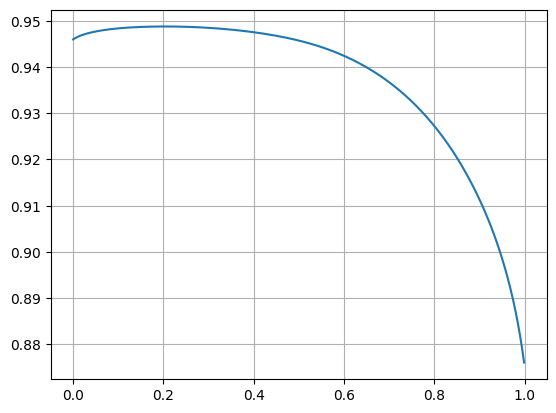

Max value:  0.9487631106022565 , at alpha =  [0.202]


In [42]:
y = mi_auc
plt.plot(alphas, y)
ymax = max(y)
xpos = np.where(y == ymax)
xmax = alphas[xpos]

plt.grid()
plt.show()

print('Max value: ', ymax, ', at alpha = ', xmax)

In [43]:
summ = np.add(mi_auc, ma_auc)
summ = np.add(summ, mi_f1)
summ = np.add(summ, ma_f1)

In [44]:
pos = np.where(summ == max(summ))
print('pos:', pos)
print('alpha:', alphas[pos])

pos: (array([175]),)
alpha: [0.175]


In [45]:
print('micro_auc:', mi_auc[pos])
print('macro_auc:', ma_auc[pos])
print('micro-f1:', mi_f1[pos])
print('macro-f1:', ma_f1[pos])

micro_auc: [0.94873596]
macro_auc: [0.91266691]
micro-f1: [0.7014424]
macro-f1: [0.56332384]


# Training Structured Data on neural network

In [ ]:
train_df = pd.read_csv('../../Structured/train_final.csv')
train_dataset = train_df.to_dict('records')

test_df = pd.read_csv('../../Structured/test_final.csv')
test_dataset = test_df.to_dict('records')

dev_df = pd.read_csv('../../Structured/dev_final.csv')
dev_dataset = dev_df.to_dict('records')

In [ ]:
def generate_dataset(dataset):
# convert df icd9_codes column into one hot vector
    for row in dataset:
        labels = [0] * 50
        codes = list(row['ICD9_CODE'].split(";"))
        for i in range(len(codes)):
            labels[icd9.index(codes[i])] = 1
        row['ICD9_CODE'] = labels

        # get list of features (lab events item ids) 
        keys = dataset[0].keys()
        keys = list(keys)
        keys.remove('SUBJECT_ID')
        keys.remove('HADM_ID')
        keys.remove('ICD9_CODE')

    # Create dataset from df feature values
    X = []
    y = []
    for row in dataset:
        x = []
        for key in keys:
            x.append(row[key])
        X.append(x)
        y.append(row['ICD9_CODE'])
    return X, y

In [ ]:
X_train, y_train = generate_dataset(train_dataset)
X_test, y_test = generate_dataset(test_dataset)
X_train = np.array(X_train)
y_test = np.array(y_test)
y_train = np.array(y_train)
X_test = np.array(X_test)

In [ ]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
class StructuredModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features = 1530, out_features = 1024)
        self.linear_layer2 = nn.Linear(in_features = 1024, out_features = 512)
        self.linear_layer3 = nn.Linear(in_features = 512, out_features = 256)
        self.linear_layer4 = nn.Linear(in_features = 256, out_features = 128)
        self.linear_layer5 = nn.Linear(in_features = 128, out_features = 64)
        self.linear_layer6 = nn.Linear(in_features = 64, out_features = 50)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        op1 = self.linear_layer1(x)
        op1a = torch.tanh(op1)
        op2 = self.linear_layer2(op1a)
        op2a = torch.tanh(op2)
        op3 = self.linear_layer3(op2a)
        op3a = torch.tanh(op3)        
        op4 = self.linear_layer4(op3a)
        op4a = torch.tanh(op4)
        op5 = self.linear_layer5(op4a)
        op5a = torch.tanh(op5)
        op6 = self.linear_layer6(op5a)
        output = torch.sigmoid(op6)
        return output

In [ ]:
smodel = StructuredModel()
smodel.to(device)
    
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = smodel.parameters(), lr = 0.001)

epochs = 500

for epoch in range(epochs):
    smodel.train()
    y_pred = smodel(X_train.float())
    loss = loss_fn(y_pred, y_train.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    smodel.eval()
    with torch.inference_mode():
        y_pred_test = smodel(X_test.float())
        loss_test = loss_fn(y_pred_test, y_test.float())
        
    if epoch %50==0:
        print(f"Epoch: {epoch} | Training Loss: {loss} | Test Loss: {loss_test}")
        scores = calculate_eval_metrics(test_scores['hadm_ids'], y_test.cpu(), y_pred_test.cpu(), True)
        keys = ['micro_auc', 'macro_auc', 'micro_f1', 'macro_f1']
        print({k:"{:.3f}".format(v) for k,v in scores.items() if k in keys})
        print()

In [ ]:
struct_input = y_pred_test

In [ ]:
struct_input = struct_input.cpu().numpy()
struct_input

In [ ]:
mi_auc = []
ma_auc = []
mi_f1 = []
ma_f1 = []

for alpha in np.arange(0.0, 1.0, 0.001):
    final_output = struct_input * alpha + unstruct_input * (1 - alpha)
    scores = calculate_eval_metrics(test_scores['hadm_ids'], y_test.cpu(), final_output, True)
    keys = ['micro_auc', 'macro_auc', 'micro_f1', 'macro_f1']
    print('aplha: ', alpha)
    print({k:"{:.3f}".format(v) for k,v in scores.items() if k in keys})
    mi_auc.append(scores['micro_auc'])
    ma_auc.append(scores['macro_auc'])
    mi_f1.append(scores['micro_f1'])
    ma_f1.append(scores['macro_f1'])
    print('\n')

In [ ]:
alphas = np.arange(0, 1, 0.001)
mi_auc = np.array(mi_auc)
ma_auc = np.array(ma_auc)
mi_f1 = np.array(mi_f1)
ma_f1 = np.array(ma_f1)

In [ ]:
y = mi_auc
plt.plot(alphas, y)
ymax = max(y)
xpos = np.where(y == ymax)
xmax = alphas[xpos]

plt.grid()
plt.show()

print('Max value: ', ymax, ', at alpha = ', xmax)

In [ ]:
summ = np.add(mi_auc, ma_auc)
summ = np.add(summ, mi_f1)
summ = np.add(summ, ma_f1)

In [ ]:
pos = np.where(summ == max(summ))
print('pos:', pos)
print('alpha:', alphas[pos])

In [ ]:
print('micro_auc:', mi_auc[pos])
print('macro_auc:', ma_auc[pos])
print('micro-f1:', mi_f1[pos])
print('macro-f1:', ma_f1[pos])